This notebook is the first of a series where I develop models of marine mammal beaching events. I use a probabilistic programming framework, specifically, bayesian generalized linear models, to tease out what data if any can be used to explain and predict events. I start with Poisson regression, which features a log link function that takes the form:
$$ 
\begin{equation}
log(\lambda) = \alpha + \sum_i^n\beta_ix_i
\end{equation}
$$
$$
\begin{equation}
y \sim Poisson(\lambda)
\end{equation}
$$

where $\alpha$ is an intercept, $\beta_i$ is a coefficient measuring the impact of predictor variable $x_i$ on the regression. It is important to realize here that neither $\alpha$ nor $\beta_i$ are deterministic variables. Rather they are probabilistic constructs characterized by a distribution and shapen initially by their respective priors, which expresses what is know *prior* to collecting the data. That knowledge is then subsequently altered by confrontation with collected observations. 
In the bayesian realm, $\alpha$ and $\beta_i$ are considered unobserved variables; not parameters. Furthermore while they might start with a distribution similar to e.g. a Normal distribution, the posterior distribution may  be far from gaussian.
Note the $\sim$ in the second equation which underlines the generative nature of these models; once fit, they can be used to run simulations of future outcomes.

First I address the identification of intercepts (no predictive features used) to check the framework makes basic sense. In the process I look at 3 different formulations

* $x^{th}$ pooled model and trace: m_px, trace_px
* $x^{th}$ unpooled model and trace: m_ux, trace_ux
* $x^{th}$ partially pooled model and trace: m_ppx, trace_ppx

where x is the modeling iteration.

I end this notebook with the use of *month* as predictive feature to tease out cyclical trends in the data
For model evaluation, I use **counter-factual plotting** and **posterior predictive checks** (**PPC**). For model comparison, selection and/or ensemble averaging,  I use the **Widely Available Information Criterion** (**WAIC**) and/or the **Leave-One-Out** (**LOO**) cross-validation.

In [1]:
import pathlib
import pickle
import sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from seaborn import heatmap, stripplot, swarmplot
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as pl
from matplotlib import rcParams
from theano import tensor as tt
from cmocean.cm import thermal

In [2]:
print('Version Info', end='\n\n')

print(f'System: {sys.version}')
print('-' * 75)
print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'PyMC3: {pm.__version__}')

Version Info

System: 3.6.3 |Anaconda custom (64-bit)| (default, Oct 13 2017, 12:02:49) 
[GCC 7.2.0]
---------------------------------------------------------------------------
pandas: 0.22.0
numpy: 1.14.2
PyMC3: 3.3


In [3]:
# graphical setup
% matplotlib inline
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['font.size'] = 16

In [4]:
# load data into pandas dataframe
home = pathlib.Path.home()
dataDir = home / 'DATA/Beaching_Project/PklJar'
with open(dataDir / 'CapeCodDataDict.pkl', 'rb') as f:
    dataDict = pickle.load(f)
    
df_total = dataDict['Targets']['TOTAL']
df_total.head() # take a look at the first few lines

,num_stranded,event
1999-03-07,6.0,1
1999-03-08,0.0,0
1999-03-09,0.0,0
1999-03-10,0.0,0
1999-03-11,0.0,0


First I am going to create a monthly resampled matrix aggregating the events by summation. This will be used later to create the last model of this notebook (I'll examine just intercepts first)

In [5]:
df_T_M = df_total.drop('num_stranded', axis=1).resample('M').sum()
df_T_M.head() # first 5 lines

,event
1999-03-31,6
1999-04-30,0
1999-05-31,0
1999-06-30,1
1999-07-31,0


In [6]:
df_T_M.describe() # statistics description of events

,event
count,190.000000
mean,0.863158
std,1.749440
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,10.000000


In [7]:
df_T_M.info(verbose=True) # overview to make sure there are no ill-conditioned data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 190 entries, 1999-03-31 to 2014-12-31
Freq: M
Data columns (total 1 columns):
event    190 non-null int64
dtypes: int64(1)
memory usage: 3.0 KB


There are 190 monthly counts of stranding events spanning March 1999 to December 2014. 
Next we model only the intercepts (average stranding rates) using three strategies. For reference, note that the *monthly average stranding rate is*:

In [8]:
df_T_M.event.mean()

0.8631578947368421

And the break down of the **monthly** event counts by value is:

In [9]:
df_T_M.event.value_counts()

0     118
1      43
2      10
4       7
6       4
3       4
10      2
9       1
8       1
Name: event, dtype: int64

In [10]:
n_obs = df_T_M.shape[0]

<u>Pooled Model</u>: 
"Pooled" here means that the observed data is assumed to be generated following a single common process, i.e. the rate of beaching is expected to be constant. A Kruchke diagram [1], below, is useful to conceptualize the model structure:
<img src="FigJar/beaching_mp_0.png">

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]
100%|██████████| 7000/7000 [00:04<00:00, 1618.55it/s]


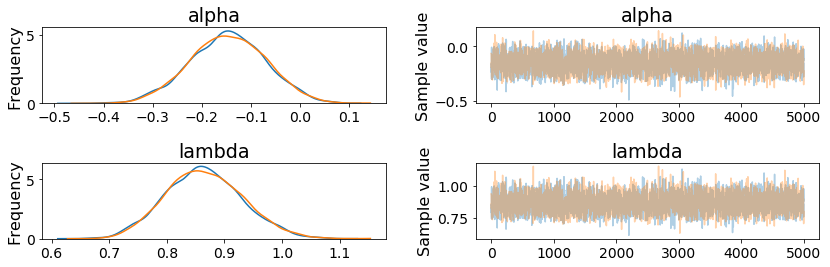

In [11]:
# pooled model mp_0
with pm.Model() as mp_0:
    alpha = pm.Normal('alpha', mu=0, sd=1) # prior
    lambda_ = pm.Deterministic('lambda', tt.exp(alpha)) # store lambda to compare to the mean above
    events_pred = pm.Poisson('events_pred', mu=lambda_, observed=df_T_M.event) # likelihood 
    trace_mp0 = pm.sample(5000, tune=2000); 
pm.traceplot(trace_mp0);

The above plots on the left shows the posterior distributrions of the intercept MCMC sampler computed 4 independent inference chains which are all lined up. Note that the mode of $\lambda$ is approx. equal to the mean events computed earlier. The traces on the right show healthy chains. Further diagnostics are available but not included here for brevity.

Next is to see what alpha corresponds to when simulating data using the results of this pooled model. Once again, note that the pooled model implies a constant rate in time.

In [12]:
alpha_mp0_post = trace_mp0.get_values('alpha', combine=True)[:, None]
lambda_mp0_post = np.exp(alpha_mp0_post.repeat(n_obs, axis=1))
med_alpha_mp0 = np.median(lambda_mp0_post, axis=0)
hpd_95_lambda_mp0_post = pm.hpd(lambda_mp0_post)

Next is to simulate observations. This is done using the posterior predictive (hereafter ppc), which is defined as the distribution of unobserved events ($y_{new}$) conditioned on available observations ($y_{observed}$), and can be written as:
$$p(y_{new} \mid  y_{observed}) = \int p(y_{new}\mid \theta)p(\theta \mid y_{observed})d\theta$$
obtained by the likelihood of $y_{new}$ given the set unobserved variables $\theta$ weighed by the latters' posterior probability and subsequently marginalized over all possible $\theta$ values.


In [13]:
ppc_mp0 = pm.sample_ppc(trace_mp0, model=mp_0, size=n_obs)['events_pred'] # get ppc for mp_0

# compute 95% credibility intervals of ppc
hpd_95_ppc_mp0 = pm.hpd(ppc_mp0)
med_ppc_mp0 = np.median(ppc_mp0, axis=0)

100%|██████████| 5000/5000 [00:01<00:00, 4086.67it/s]


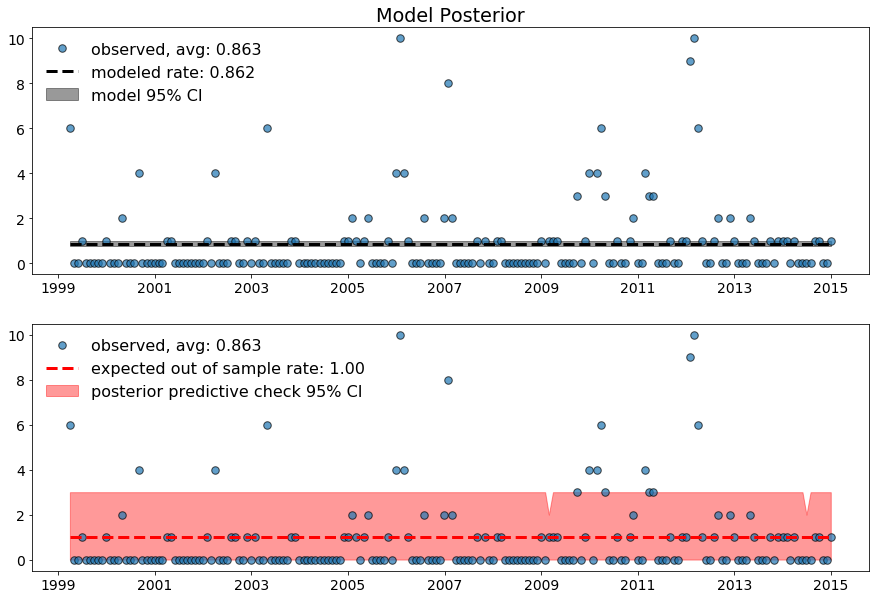

In [67]:
dates = np.array(df_T_M.index.to_datetime())
_, ax = pl.subplots(nrows=2, figsize=(15, 10))
ax[0].plot(dates, df_T_M.event, marker='.', markersize=15,
        markeredgecolor='k', ls='', label='observed, avg: %.3f' % df_T_M.event.mean(), alpha=0.7)
ax[0].plot(dates, med_alpha_mp0, color='k', ls='--', lw=3,
        label='modeled rate: %.3f' % med_alpha_mp0[0])
ax[0].fill_between(dates, y1=hpd_95_lambda_mp0_post[:,0],
                y2=hpd_95_lambda_mp0_post[:, 1], color='k', alpha=0.4,
               label='model 95% CI')
ax[0].set_title('Model Posterior')
ax[0].legend(framealpha=0)
ax[1].plot(dates, df_T_M.event, marker='.', markersize=15,
        markeredgecolor='k', ls='', label='observed, avg: %.3f' % df_T_M.event.mean(), alpha=0.7)
ax[1].plot(dates, med_ppc_mp0, ls='--', color='r', lw=3, 
        label='expected out of sample rate: %.2f' % med_ppc_mp0[0])
ax[1].fill_between(dates, y1=hpd_95_ppc_mp0[:, 0], y2=hpd_95_ppc_mp0[:, 1], color='red',
               alpha=0.4, label='posterior predictive check 95% CI')
ax[1].legend(framealpha=0);

The shortcomings of the pooled model are obvious here. The model (estimates correctly the average stranding rate of 0.86, and the PPC return a corresponding out-of-sample expectation of 1 stranding a month. However both model and PPC 95% credibility intervals (CI) fail to account for the observed variance. Next is to expore this variance a bit with an unpooled model.
<u>Unpooled Model</u>:
Here all observations are assumed to be generated from independent and unrelated processes, i.e. each observation gets its own intercept. The obligate Kruschke diagram follows:
<img src='FigJar/beaching_mu_0.png', width=600, height=300>

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]
100%|██████████| 7000/7000 [00:38<00:00, 182.96it/s]


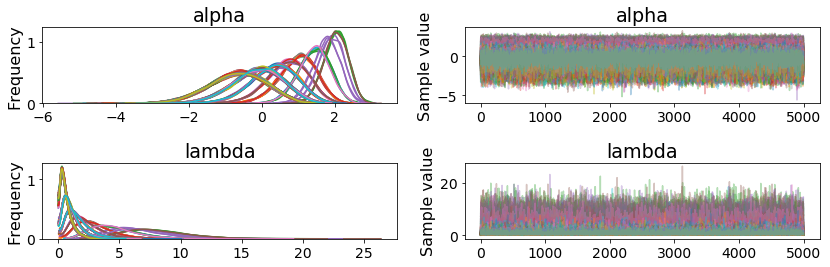

In [15]:
# unpooled model mu_0
with pm.Model() as mu_0:
    alpha = pm.Normal('alpha', 0, 1, shape=n_obs) # each event gets a prior
    lambda_ = pm.Deterministic('lambda', tt.exp(alpha))
    events_pred = pm.Poisson('events_pred', lambda_, observed=df_T_M.event)
    trace_mu0 = pm.sample(5000, tune=2000);
pm.traceplot(trace_mu0);

I've only plotted posterior distributions and chains for $\alpha$. These are sufficient to show good convergence and that there is significant dispersion in intercepts. This is not very useful beyond this point, because I'm interested in the commonality of each event. This is where the flexibility of a hierarchical model can be useful. Hierarchical models are also known as multilevel or partially pooled models. 
<br>
<u>Parially Pooled Model</u>: The partially pooled model allows data to be grouped in a meaningful way, while retaining a commonality in the generation process. In practice, this means that each group is allowed its own set of priors, but these priors are linked by common *hyperprior(s)*. During inference, the data helps determine the hyperprior(s), revealing in the process insight about how the data generation process, conditioned on the model. The Kruschke diagram below illustrates the model structure. Note the half-Cauchy hyperprior, justfied by [2] and [3]
<br>
The priors of the intercepts have a common hyperprior on their variance referred to below as *sig_alph*.This next
<img src="FigJar/beaching_mpp_0.png", width=600, height=300>

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, sig_alph_log__]
100%|██████████| 7000/7000 [00:53<00:00, 130.81it/s]
The number of effective samples is smaller than 25% for some parameters.


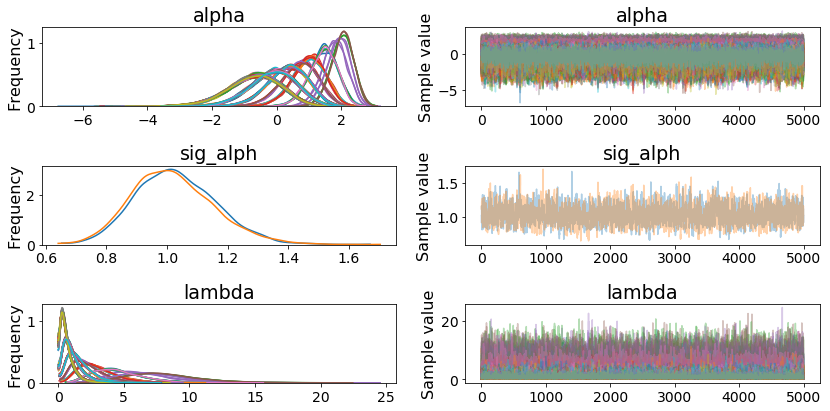

In [16]:
# partially pooled model
with pm.Model() as mpp_0:
    sig_alph = pm.HalfCauchy('sig_alph', beta=2) # prior to the variance 
    alpha = pm.Normal('alpha', 0, sig_alph, shape=df_T_M.event.shape[0])
    lambda_ = pm.Deterministic('lambda', tt.exp(alpha))
    events_pred = pm.Poisson('events_pred', lambda_, observed=df_T_M.event)
    trace_mpp0 = pm.sample(5000, tune=2000)
pm.traceplot(trace_mpp0);

The $\alpha$'s posterior distribution are comparable to those of the previous model. However, the model was able to converge on a commong variance, different than 0. One thing that would be visible with further scrutiny that I don't delve into for brevity, is that the uncertainties of the posterior of $\alpha$ are somewhat tighter in a few of the cases. This is referred to as shrinkage and is a common benefit of using hierachical modeling.

The next step is to compare these models
Inter-model comparison of intercept-only models using WAIC. WAIC is an information measure used to estimate the out-of-sample (unobserved data) deviance. It is a fully bayesian construct in that it uses the posterior distribution as well as the posterior predictive to produce said estimate. 

In [17]:
traces = [trace_mu0, trace_mp0, trace_mpp0]
models = [mu_0, mp_0, mpp_0]
modelNames = ['unpooled', 'pooled', 'part. pld.']

In [18]:
dfcomp = pm.compare(traces, models).iloc[:, :-1]
dfcomp.index = [modelNames[i] for i in dfcomp.index]
dfcomp

,WAIC,pWAIC,dWAIC,weight,SE,dSE
part. pld.,465.75,57.56,0,1,18,0
unpooled,466.36,57.14,0.61,0,17.76,0.56
pooled,613.27,3.44,147.53,0,68.38,53.83


The above shows without ambiguity that the partial pooling (**mpp0**) is the better model. Indeed, the weight column can be taken as the probabilility that the corresponding model will perform better than the others. Hereafter I use hierarchical models as a more robust approach.
Note that in common bayesian practice, an unpooled model is nonsensical, and was included here for illustration. I drop this model and will not consider it hereafter:

In [19]:
traces = traces[1:]
models = models[1:]
modelNames = modelNames[1:]

In [20]:
# GET MODEL POSTERIOR
alpha_mpp0_post = trace_mpp0.get_values('alpha', combine=True)
lambda_mpp0_post = np.exp(alpha_mpp0_post)
med_alpha_mpp0 = np.median(lambda_mpp0_post, axis=0)
hpd_95_lambda_mpp0_post = pm.hpd(lambda_mpp0_post)

In [21]:
# GET POSTERIOR PREDICTIVE CHECK
ppc_mpp0 = pm.sample_ppc(trace_mpp0, model=mpp_0, progressbar=False)['events_pred'] # get ppc for mp_0
# compute 95% credibility intervals of ppc
hpd_95_ppc_mpp0 = pm.hpd(ppc_mpp0)
med_ppc_mpp0 = np.median(ppc_mpp0, axis=0)

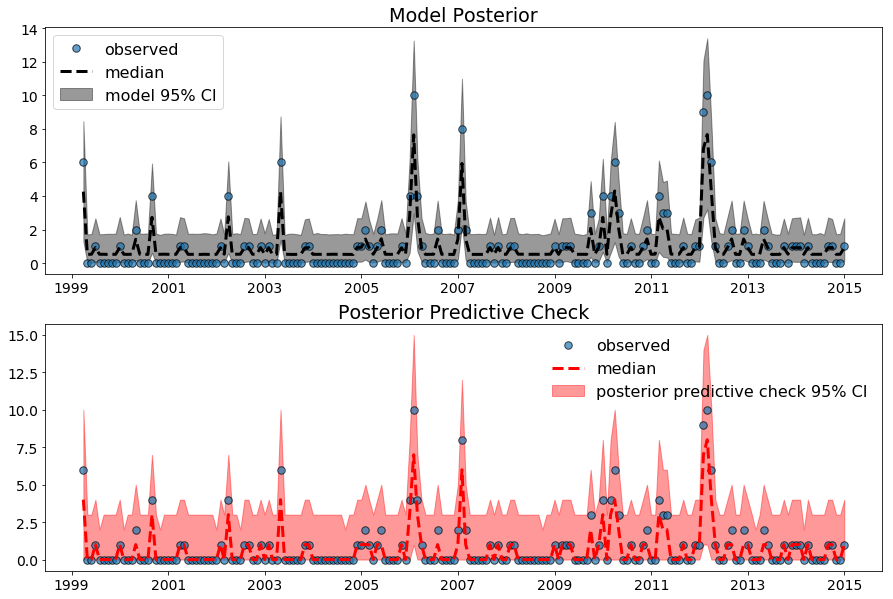

In [22]:
# PLOT POSTERIOR ASSESSMENTS
_, ax = pl.subplots(nrows=2,figsize=(15, 10))
ax[0].plot(dates, df_T_M.event, marker='.', markersize=15,
        markeredgecolor='k', ls='', label='observed', alpha=0.7)
ax[0].plot(dates, med_alpha_mpp0.T, color='k', ls='--', lw=3,
        label='median')
ax[0].fill_between(dates, y1=hpd_95_lambda_mpp0_post[:,0],
                y2=hpd_95_lambda_mpp0_post[:, 1], color='k', alpha=0.4,
               label='model 95% CI');
ax[0].set_title('Model Posterior')
ax[0].legend()
ax[1].plot(dates, df_T_M.event, marker='.', markersize=15,
        markeredgecolor='k', ls='', label='observed', alpha=0.7)
ax[1].plot(dates, med_ppc_mpp0, ls='--', color='r', lw=3, 
        label='median')
ax[1].fill_between(dates, y1=hpd_95_ppc_mpp0[:, 0], y2=hpd_95_ppc_mpp0[:, 1], color='red',
               alpha=0.4, label='posterior predictive check 95% CI')
ax[1].set_title('Posterior Predictive Check')
ax[1].legend(framealpha=0);

<u>Partially Pooled Model with Month as Predictor</u>:
Here I add a first feature, which is the month of occurrence of the event. This I pull out directly from the date index of the dataframe. The idea here is to identify cyclical trends in the data. The next few lines create the data needed.

In [23]:
# get month as 0-based index for each event
df_T_M['month'] = df_T_M.index.month - 1
# get year for each event
df_T_M['year'] = df_T_M.index.year

In [24]:
# how many groups per month
df_T_M.month.value_counts()

11    16
10    16
9     16
8     16
7     16
6     16
5     16
4     16
3     16
2     16
1     15
0     15
Name: month, dtype: int64

In [25]:
# the month column is great for pymc3's indexing purpose but not ideal for clear plotting
# i'll add corresponding month names in a different column:
df_T_M['month_name'] = df_T_M.index.strftime('%b')

In [26]:
# first few lines of the dataframe with the new data added
df_T_M.head()

,event,month,year,month_name
1999-03-31,6,2,1999,Mar
1999-04-30,0,3,1999,Apr
1999-05-31,0,4,1999,May
1999-06-30,1,5,1999,Jun
1999-07-31,0,6,1999,Jul


Next is to create a pivot table to look at the data along two axes; year and month.

In [27]:
monYearPivot = df_T_M.sort_values('month').pivot_table(values='event', index='year',
                                                       columns=['month','month_name'])

In [28]:
# Let's take a look at what the distribution by month and year looks like. columns are months, rows are years
monYearPivot

month,0,1,2,3,4,5,6,7,8,9,10,11
month_name,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
year,,,,,,,,,,,,
1999,NaN,NaN,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2000,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
2001,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002,1.0,0.0,4.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2003,1.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2005,2.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0
2006,10.0,4.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0


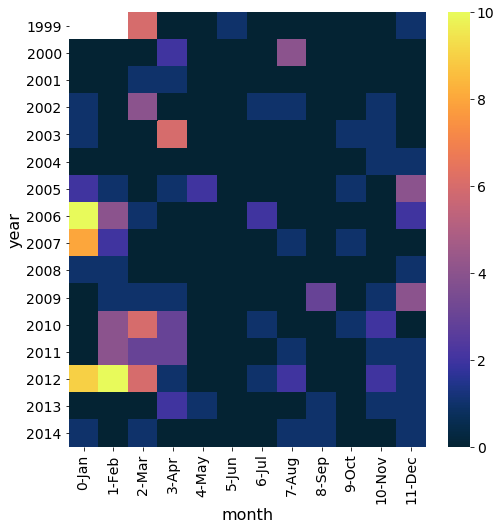

In [31]:
# and graphically
_, ax = pl.subplots(figsize=(8,8))
heatmap(monYearPivot, ax=ax, cmap=thermal);
ax.set_xlabel('month');

Now I model the impact a given month has on the overall stranding rate.
<img src="FigJar/beaching_mpp__1.png", width=600, height=300>

In [32]:
n_months = df_T_M.month.unique().size

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [alpha_month, sigma_month_log__]
100%|██████████| 7000/7000 [00:13<00:00, 527.40it/s]


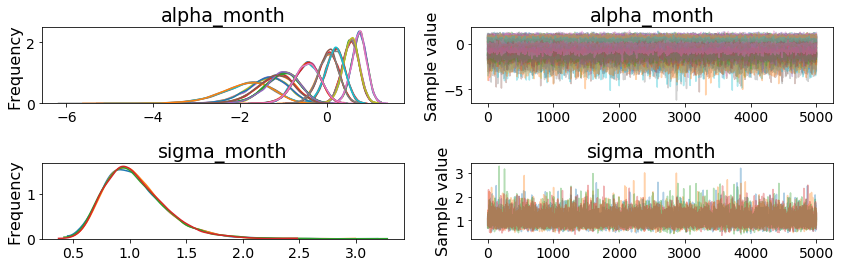

In [35]:
with pm.Model() as mpp_1:
    # priors
   # alpha = pm.Normal('alpha', 0, 1)
    sigma_month = pm.HalfCauchy('sigma_month', 1)
    alpha_month = pm.Normal('alpha_month', 0, sigma_month, shape=n_months)
    # link
    lambda_ = pm.math.exp(alpha_month[df_T_M.month.values])
    # likelihood
    events = pm.Poisson('events', lambda_, observed=df_T_M.event)
    # sampling
    trace_mpp1 = pm.sample(5000, tune=2000, chains=4)
pm.traceplot(trace_mpp1);

Examining the impact each month has on the number of events we see that in terms of effects on the number of beachings:

* the common mean, alpha is now centered around -0.5, which gives a background beaching rate of 0.6/month
* the first 3 months (Jan, Feb, Mar) have a significantly positive impact
* Apr and Dec have also positive impact that, however is not significantly different than 0
* May-July and Sept-Oct have a negative impact, but ony June is significantly different than 0.

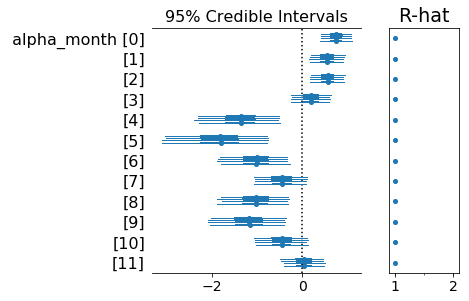

In [36]:
pm.forestplot(trace_mpp1, varnames=['alpha_month']);

Once again, comparing all models including this latest (**part. pld. w/ 1f**)...

In [37]:
traces.append(trace_mpp1)
models.append(mpp_1)
modelNames.append('part. pld. w/ 1f')

In [38]:
df_comp = pm.compare(traces, models, ic='WAIC').iloc[:, :-1]
df_comp.index = [modelNames[i] for i in df_comp.index]
df_comp

,WAIC,pWAIC,dWAIC,weight,SE,dSE
part. pld.,465.75,57.56,0,0.6,18,0
part. pld. w/ 1f,537.55,22.57,71.8,0.4,48.22,34.18
pooled,613.27,3.44,147.53,0,68.38,53.83


While the partially pooled model with 1 feature  **(part. pld. w/ 1f)** is not the better ranking model, the expected distribution of new data is such that the table above suggests a weighted averaging of both hierarchical (partially pooled models) models,  and mpp_1 by 60% and 40%, respectively.

In [41]:
# GET MODEL POSTERIOR BY MONTH
alpha_month_post = trace_mpp1.get_values('alpha_month', combine=True)
lambda_mpp1_post = np.exp(alpha_month_post)
med_alpha_mpp1 = np.median(lambda_mpp1_post, axis=0)
hpd_95_lambda_mpp1_post = pm.hpd(lambda_mpp1_post)
df_mpp1 = pd.DataFrame(np.c_[med_alpha_mpp1, hpd_95_lambda_mpp1_post], columns=['med', 'hpd95_lo', 'hpd95_hi'])

In [62]:
# GET MODEL POSTERIOR
lambda_mpp1_post_ = np.exp(alpha_month_post[:,df_T_M.month])
med_lambda_mpp1_ = np.median(lambda_mpp1_post_, axis=0)
hpd_95_lambda_mpp1_post_ = pm.hpd(lambda_mpp1_post_)

In [64]:
hpd_95_lambda_mpp1_post_.shape

(190, 2)

In [ ]:
# GET POSTERIOR PREDICTIVE CHECK
ppc_mpp1 = pm.sample_ppc(trace_mpp1, model=mpp_1, progressbar=False)['events'] # get ppc for mp_0
# compute 95% credibility intervals of ppc
hpd_95_ppc_mpp1 = pm.hpd(ppc_mpp1)
med_ppc_mpp1 = np.median(ppc_mpp1, axis=0)

In [86]:
df_T_M.iloc[10:22]

,event,month,year,month_name
2000-01-31,0,0,2000,Jan
2000-02-29,0,1,2000,Feb
2000-03-31,0,2,2000,Mar
2000-04-30,2,3,2000,Apr
2000-05-31,0,4,2000,May
2000-06-30,0,5,2000,Jun
2000-07-31,0,6,2000,Jul
2000-08-31,4,7,2000,Aug
2000-09-30,0,8,2000,Sep
2000-10-31,0,9,2000,Oct


In [90]:
df_mpp1['med_ppc'] = med_ppc_mpp1[10:22]
df_mpp1['hpd95_ppc_lo'] = hpd_95_ppc_mpp1[10:22, 0]
df_mpp1['hpd95_ppc_hi'] = hpd_95_ppc_mpp1[10:22, 1]

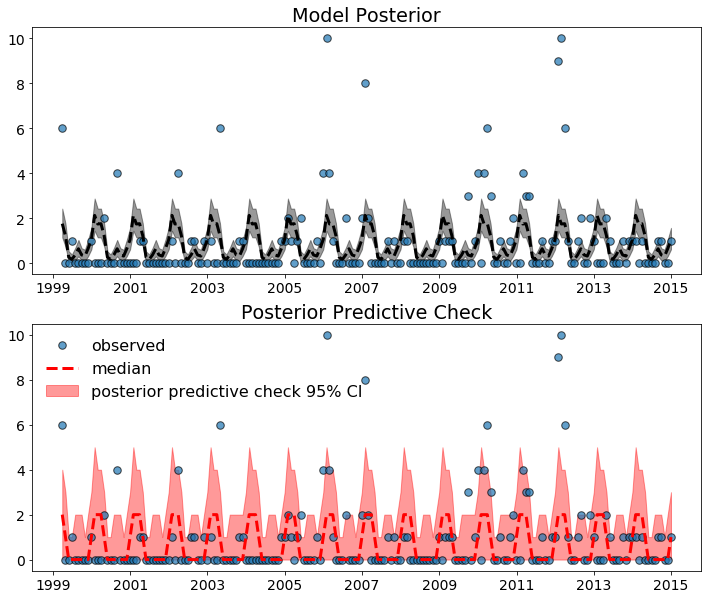

In [93]:
_, ax = pl.subplots(nrows=2, figsize=(12, 10))
ax[0].plot(dates, df_T_M.event, marker='.', markersize=15,
        markeredgecolor='k', ls='', label='observed', alpha=0.7)
ax[0].plot(dates, med_lambda_mpp1_.T, color='k', ls='--', lw=3,
        label='median')
ax[0].fill_between(dates, y1=hpd_95_lambda_mpp1_post_[:,0],
                y2=hpd_95_lambda_mpp1_post_[:, 1], color='k', alpha=0.4,
               label='model 95% CI');
ax[0].set_title('Model Posterior')
                                      
ax[1].plot(dates, df_T_M.event, marker='.', markersize=15,
        markeredgecolor='k', ls='', label='observed', alpha=0.7)
ax[1].plot(dates, med_ppc_mpp1, ls='--', color='r', lw=3, 
        label='median')
ax[1].fill_between(dates, y1=hpd_95_ppc_mpp1[:, 0], y2=hpd_95_ppc_mpp1[:, 1], color='red',
               alpha=0.4, label='posterior predictive check 95% CI')
ax[1].set_title('Posterior Predictive Check')
ax[1].legend(framealpha=0);

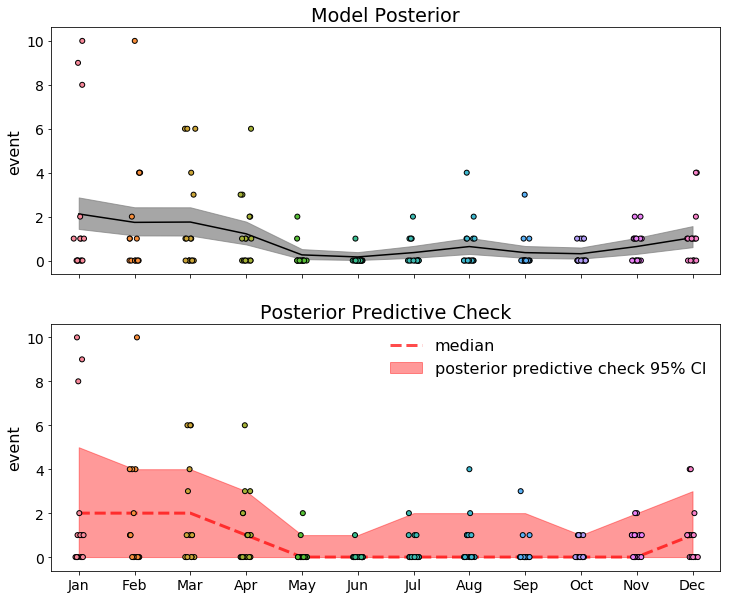

In [101]:
_, ax = pl.subplots(nrows=2, figsize=(12,10), sharex=True)
stripplot(x='month_name', y='event', data=df_T_M.sort_values('month'), ax=ax[0], jitter=True,
         edgecolor='k', linewidth=1)
ax[0].plot(df_mpp1.med, color='k', label='median')
ax[0].fill_between(df_mpp1.index, y1=df_mpp1.hpd95_lo, y2=df_mpp1.hpd95_hi, alpha=0.7, color='gray');
ax[0].set_title('Model Posterior')
ax[0].set_xlabel('')
stripplot(x='month_name', y='event', data=df_T_M.sort_values('month'), ax=ax[1], jitter=True,
         edgecolor='k', linewidth=1)
ax[1].plot(df_mpp1.med_ppc, ls='--', lw=3, color='r', label='median', alpha=0.7)
ax[1].fill_between(df_mpp1.index, y1=df_mpp1.hpd95_ppc_lo, y2=df_mpp1.hpd95_ppc_hi, color='red',
               alpha=0.4, label='posterior predictive check 95% CI')
ax[1].set_xlabel('')
ax[1].set_title('Posterior Predictive Check')
ax[1].legend(framealpha=0);

Now, we can add predictors to our model and see how well we improve. One remaining problem is that the zero-event may be inflated. This may arise because often there is more than one reason for not observing an event, even if the necessary or threshold conditions have been satisfied. In the case of count data such as these, this can be addressed by using a zero-inflated poisson process, where the 0-event is parameterized separately from the non-zero event. This is an example of a mixture model the exploration of which, in the context of this data, will be the subject of a subsequent notebook along with the use of additional features (predictor variables).

In [102]:
# Make a dictionary to pickle (serialize and save as binary file) traces and models for later use
modeldict = {k:v for k, v in zip(modelNames, models)}
tracedict = {k:v for k, v in zip(modelNames, traces)}
dfsdict = {'dfmpp1': df_mpp1,
          'df_monthly': df_T_M}
glmdict = dict(models=modeldict, traces=tracedict, df=dfsdict)

with open('../PklJar/models/glm1.pkl', 'wb') as f:
    pickle.dump(glmdict, f)

<u>Refs:</u>
<br>
[1] Kruschke, JK (2015) Doing Bayesian Data Analysis, Second Edition: A Tutorial with R, JAGS, and Stan. Academic Press / Elsevier.
<br>
[2] Gelman A (2006) "Prior distributions for variance parameters in hierarchical models". Bayesian Anal. 1(3)515–533.
<br>
[3] Polson NG and Scott JG (2012) "On the Half-Cauchy Prior for a Global Scale Parameter". Bayesian Anal. 7(4) 887-902.

